# Hough Transform

Submitted by:
  Saurabh Kumar (SC22B146)

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, transform, feature, exposure
from skimage.filters import threshold_otsu
from skimage.transform import rotate, hough_line, hough_line_peaks
from skimage.feature import canny
from scipy.stats import mode


Load and display the sample image.
You can upload your own skewed document image here

In [140]:
path1 = 'tree_skewed2.png'
image = io.imread(path1)

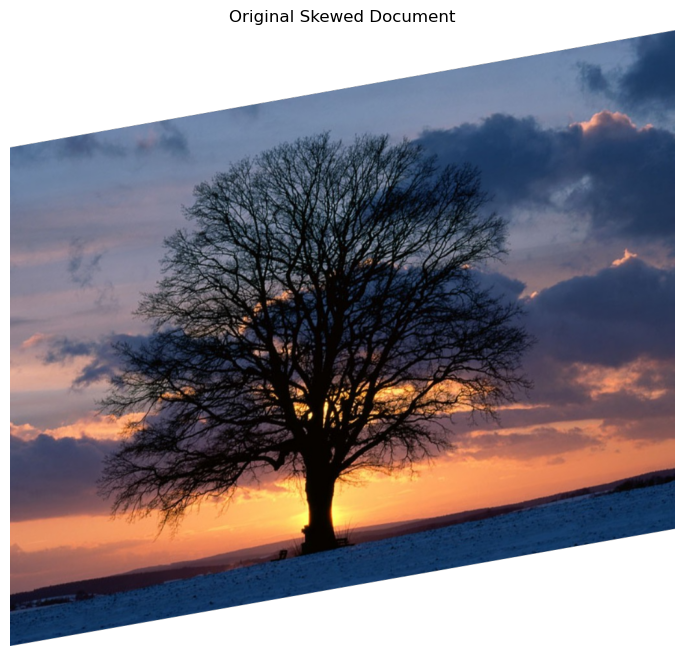

In [141]:
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.title('Original Skewed Document')
plt.axis('off')
plt.show()


In [142]:
# PART 1: Image Binarization 
# -----------------------------------------------
# TODO: Complete the binarizeImage function 
# Convert the image to grayscale and apply Otsu's thresholding
import cv2

def binarizeImage(RGB_image):
    """
    Convert an RGB image to binary using Otsu's thresholding
    
    Parameters:
    -----------
    RGB_image : ndarray
        Input RGB image
        
    Returns:
    --------
    binary_image : ndarray
        Binary image (True for foreground, False for background)
    """
    
    # 1. Convert RGB_image to grayscale
    gray_image = cv2.cvtColor(RGB_image, cv2.COLOR_RGB2GRAY)
    
    # 2. Apply Otsu's thresholding
    threshold_value, thresholded_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 3. Return binary image where text is foreground (True)
    # Convert binary image to boolean
    binary_image = thresholded_image == 255  # Assuming black text on a white background
    
    return binary_image

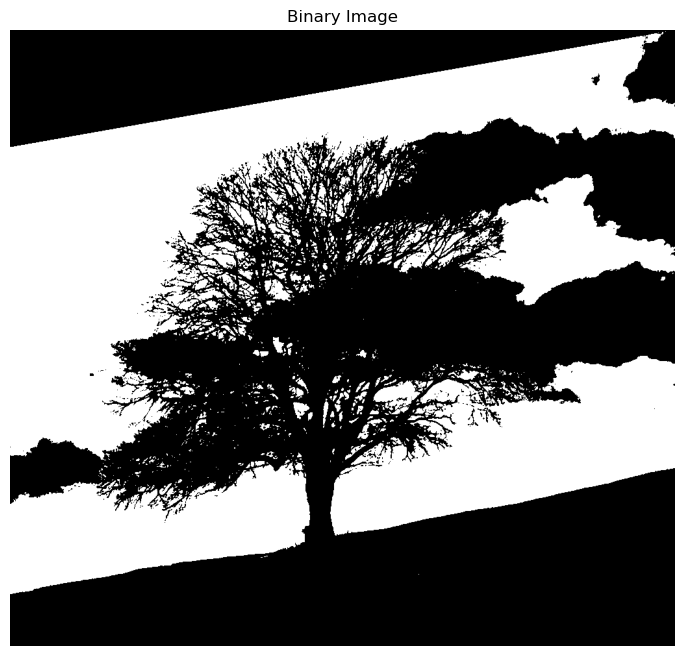

In [143]:
# Test your implementation
binary_image = binarizeImage(image)

plt.figure(figsize=(10, 8))
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

In [144]:
# PART 2: Edge Detection 
# -----------------------------------------------
# Implement edge detection using Sobel filter

def findEdges(binary_image):
    """
    Find edges in a binary image using Sobel filter
    
    Parameters:
    -----------
    binary_image : ndarray
        Binary image
        
    Returns:
    --------
    edge_image : ndarray
        Image containing detected edges
    """
    # This part is implemented for you
    edge_image = filters.sobel(binary_image)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(edge_image, cmap='gray')
    plt.title('Edge Image')
    plt.axis('off')
    plt.savefig('edge_image.png')
    
    return edge_image

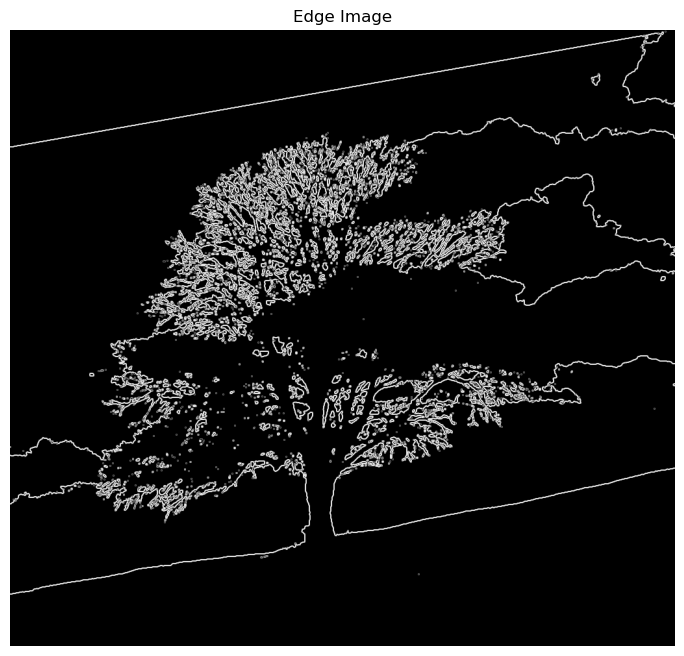

In [145]:
# Test edge detection
edge_image = findEdges(binary_image)

In [146]:
# PART 3: Skew Angle Detection 
# -----------------------------------------------
# TODO: Complete the findTiltAngle function
# Use Hough transform to detect lines and find the dominant angle

def findTiltAngle(edge_image):
    """
    Detect the skew angle using Hough transform
    
    Parameters:
    -----------
    edge_image : ndarray
        Edge image
        
    Returns:
    --------
    angle : float
        Angle to rotate the image (in degrees)
    """
    # Perform Hough transform
    h, theta, d = hough_line(edge_image)
    
    # 1. Extract the peaks from the Hough transform
    accum, angles, dists = hough_line_peaks(h, theta, d)
    angles_deg = np.rad2deg(angles) # Convert angles from radians to degrees

    # 2. Calculate the dominant angle from the detected lines
    dominant_angle = np.median(angles_deg)  # Median to reduce outliers

    # 3. Convert the angle to the correct rotation angle
    #    (Hint: Document text lines are usually horizontal, 
    #     so you need to adjust the angle accordingly)
    if dominant_angle > 45:
        correction_angle = dominant_angle - 90
    elif dominant_angle < -45:
        correction_angle = dominant_angle + 90
    else:
        correction_angle = dominant_angle
    
    # Visualize the detected lines (implemented for you)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(edge_image, cmap='gray')
    
    # Get origin point for plotting lines
    origin = np.array((0, edge_image.shape[1]))
    
    # Plot detected lines
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        ax.plot(origin, (y0, y1), '-r')
    
    ax.set_xlim(origin)
    ax.set_ylim((edge_image.shape[0], 0))
    ax.set_title('Detected Lines')
    ax.set_axis_off()
    plt.savefig('hough_lines.png')
    plt.show()
    
    return correction_angle

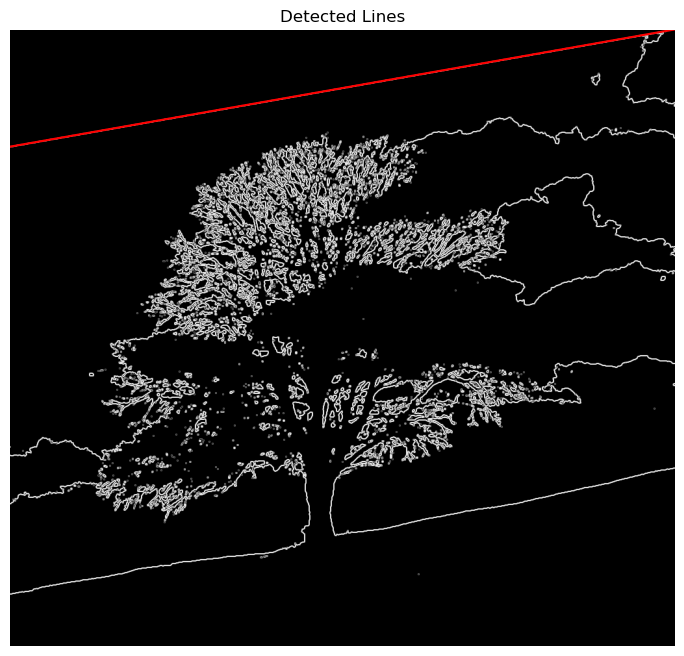

Detected skew angle: -10.00 degrees


In [147]:
# Test angle detection
angle = findTiltAngle(edge_image)
print(f"Detected skew angle: {angle:.2f} degrees")

In [148]:
# PART 4: Image Rotation 
# -----------------------------------------------
# TODO: Complete the rotateImage function
# Apply rotation to correct the skew

def rotateImage(RGB_image, angle):
    """
    Rotate image to correct skew
    
    Parameters:
    -----------
    RGB_image : ndarray
        Original RGB image
    angle : float
        Rotation angle in degrees
        
    Returns:
    --------
    rotated_image : ndarray
        Corrected image
    """

    # Get image dimensions
    (h, w) = RGB_image.shape[:2]

    # Compute the center of the image
    center = (w // 2, h // 2)

    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 1. Rotate the image using the detected angle
    # Perform affine transformation (rotation)
    rotated_image = cv2.warpAffine(RGB_image, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Display and save the result
    plt.figure(figsize=(10, 8))
    plt.imshow(rotated_image)
    plt.title('Deskewed Image')
    plt.axis('off')
    plt.savefig('deskewed_image.png')
    plt.show()
    
    # 2. Return the rotated image
    return rotated_image

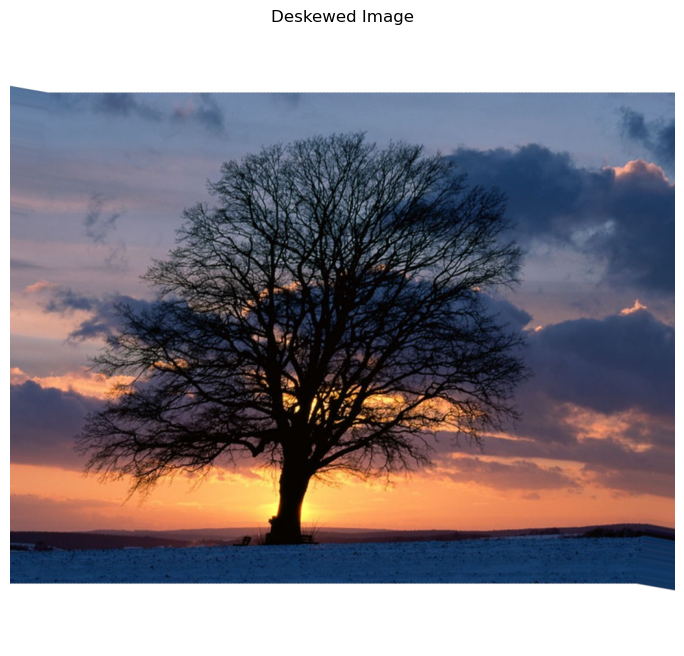

In [149]:
# Test image rotation
corrected_image = rotateImage(image, angle)


In [150]:
# PART 5: Complete Pipeline 
# -----------------------------------------------
# The complete document deskewing pipeline

def deskewPipeline(image_path):
    """
    Complete pipeline to deskew a document image
    
    Parameters:
    -----------
    image_path : str
        Path to input image
        
    Returns:
    --------
    corrected_image : ndarray
        Deskewed image
    """
    # This is implemented for you
    # Load image
    image = io.imread(image_path)
    
    # Display original image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    # Apply the pipeline
    binary_image = binarizeImage(image)
    edge_image = findEdges(binary_image)
    angle = findTiltAngle(edge_image)
    corrected_image = rotateImage(image, angle)
    
    print(f"Document deskewed. Detected angle: {angle:.2f} degrees")
    
    return corrected_image

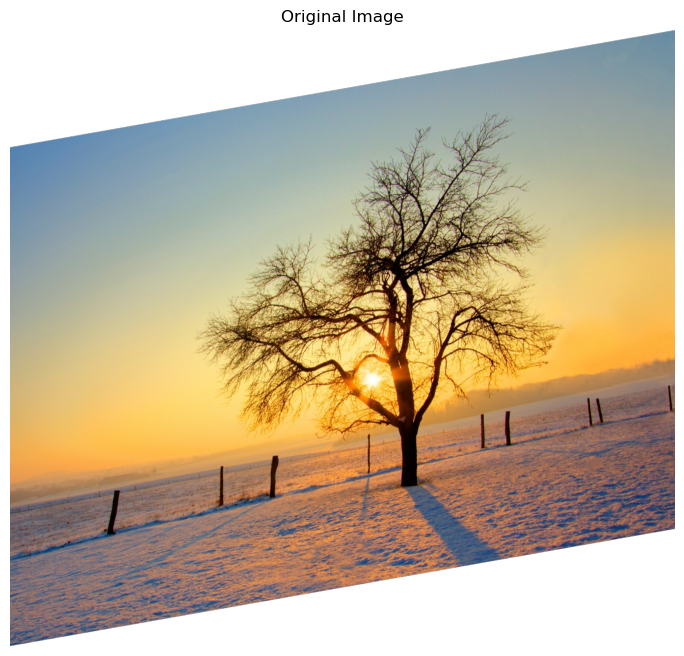

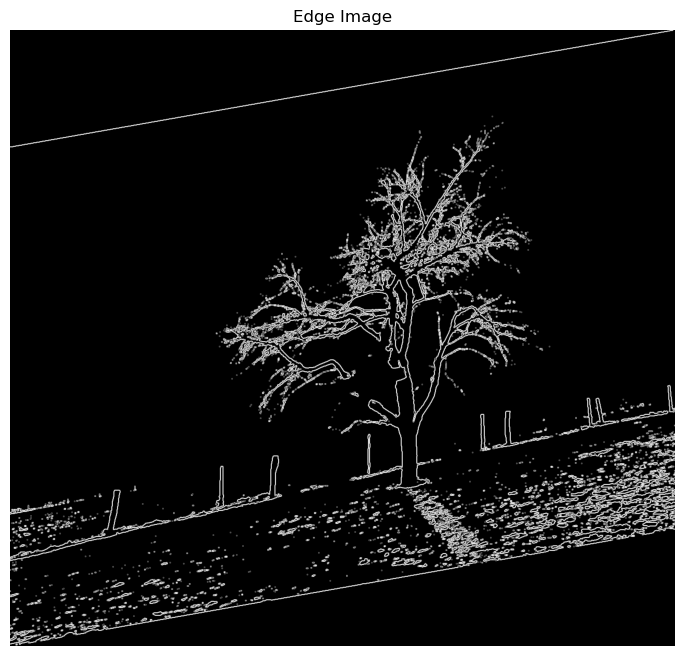

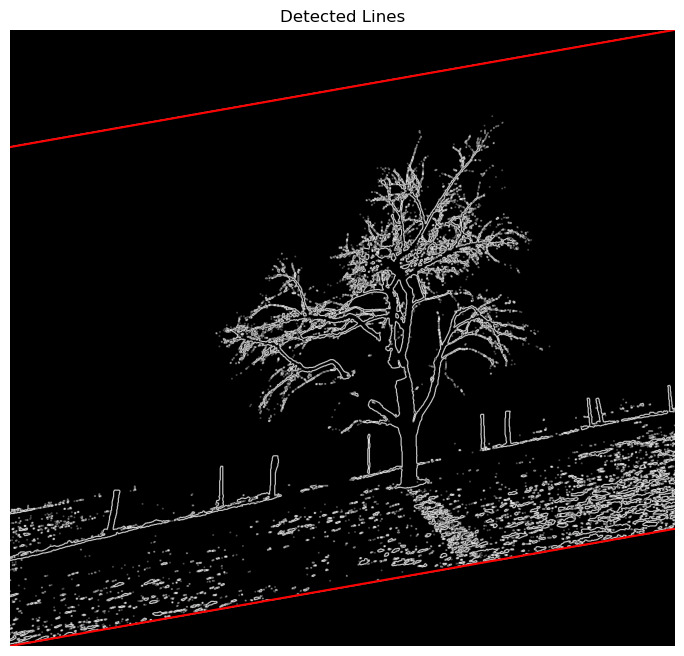

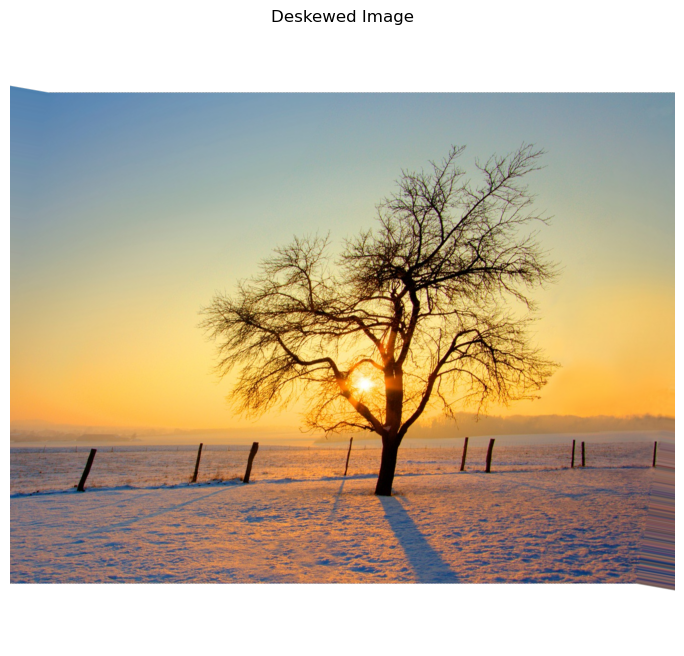

Document deskewed. Detected angle: -10.00 degrees


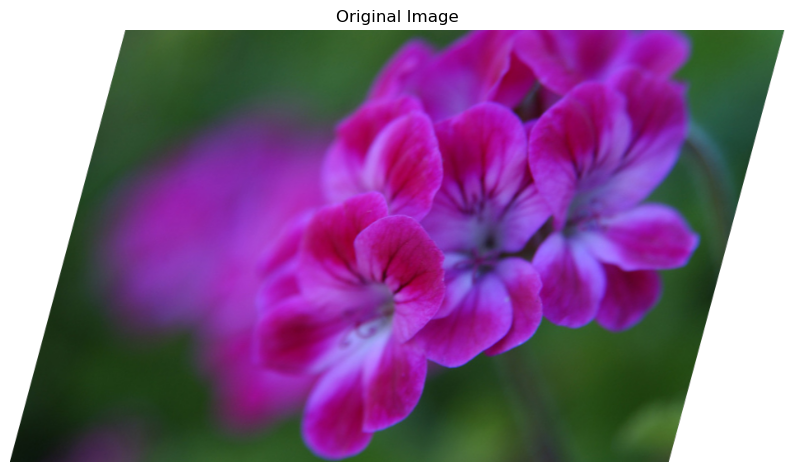

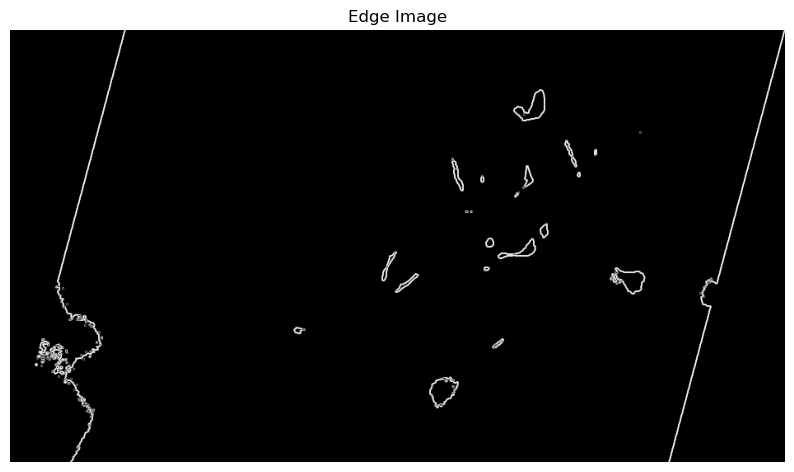

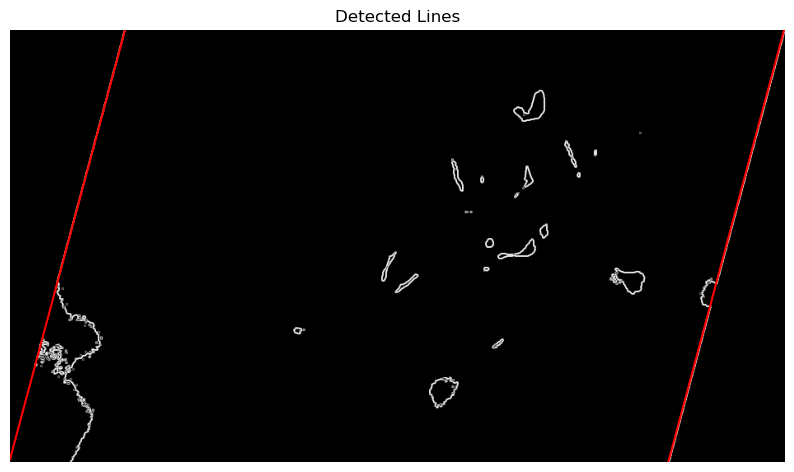

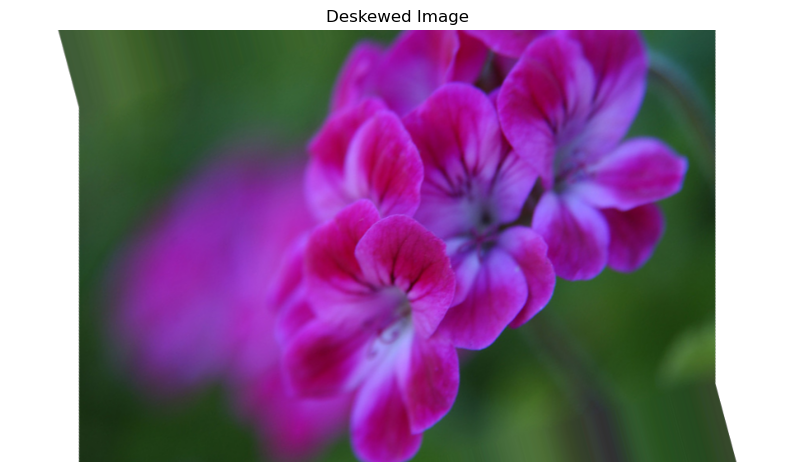

Document deskewed. Detected angle: 15.00 degrees


array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [151]:
path2 = 'tree_skewed1.png'
deskewPipeline(path2)

path3 = 'flower_skewed.gif'
deskewPipeline(path3)

## SUBMISSION INSTRUCTIONS:
 1. Fill in the missing code sections
 2. Run the notebook on at least 3 test images
 3. Add your answers to the questions above
 4. Submit the completed notebook and the test results